
# Schedulers

## Dask's schedulers

- "threaded": a scheduler backed by a thread pool
- "processes": a scheduler backed by a process pool
- "single-threaded" (aka "sync"): a synchronous scheduler, good for debugging
- distributed: a distributed scheduler for executing graphs on multiple machines, see below.

## Select a scheduler

```python
with dask.config.set(scheduler='processes'):
    # set temporarily fo this block only
    myvalue.compute()

dask.config.set(scheduler='processes')
# set until further notice
```

## Making a cluster

* Locally using `LocalCluster` class
* Kubernetes using https://github.com/dask/dask-kubernetes
* Job schedulers like PBS, SLURM, and SGE https://dask-jobqueue.readthedocs.io
* Start `dask-scheduler` and `dask-worker` explicitly

In [1]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(
    dashboard_address="0.0.0.0:8000",
    n_workers=4,
    threads_per_worker=2
)
cluster

In [2]:
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:39493 Dashboard: http://127.0.0.1:8000/status,Cluster Workers: 4 Cores: 8 Memory: 16.82 GB


## Executing with the distributed client

* Once you instantiate a client, it's the default
* Use the dashboard to confirm
* The dashboad gives great insight into a what's happening

In [3]:
from dask import delayed
import time

def inc(x):
    time.sleep(5)
    return x + 1

def dec(x):
    time.sleep(3)
    return x - 1

def add(x, y):
    time.sleep(7)
    return x + y

In [4]:
%%time
x = delayed(inc)(1)
y = delayed(dec)(2)
total = delayed(add)(x, y)

3

Calling compute on the object immediately executes the computations and fetches the results

In [ ]:
%%time
total.compute()

The distributed Scheduler offers also a similar interface to `concurrent.futures` by using 
Client.submit and/or Client.compute

These calls immediately return the control, execute the computation and allow you to wait for the results later on

In [14]:
future = client.compute(total)

In [15]:
from distributed import progress

progress(future)

VBox()

In [12]:
# Blocks until result is ready
client.gather(future)

Client Scheduler: tcp://127.0.0.1:39493 Dashboard: http://127.0.0.1:8000/status,Cluster Workers: 4 Cores: 8 Memory: 16.82 GB


## Excursion: DataFrame storage

* Normally table-like data comes as CSV
* Decompressing text and parsing CSV files is expensive
* Alternatives:
 * HDF5 in the scientific work
 * Apache Parquet in the industry
* Blog Post: https://tech.jda.com/efficient-dataframe-storage-with-apache-parquet/

## Convert taxi dataset to Parquet

This gives us the chance to use the distributed scheduler

In [17]:
import os
nytaxi_directory = '/srv/taxi-data-csv'
nytaxi_parquet_directory = os.path.expanduser("~/taxi-data-parquet")
if not os.path.exists(nytaxi_parquet_directory):
    os.mkdir(nytaxi_parquet_directory)

In [19]:
import glob

csv_files = glob.glob(os.path.join(nytaxi_directory, '*.csv'))
len(csv_files)

12

In [20]:
from dask import delayed
import pandas as pd

@delayed
def read_taxi_df(filename):
    # As usual, we need do to some essential data cleaning to get
    # the correct data types.
    df = pd.read_csv(
        csv_files[0],
        parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
        infer_datetime_format=True,
    )
    df['store_and_fwd_flag'] = (df['store_and_fwd_flag'] == 'Y')
    return df

In [21]:
import dask

tasks = [(f, read_taxi_df(f)) for f in csv_files]
tasks

[('/srv/taxi-data-csv/yellow_tripdata_2017-06.csv',
  Delayed('read_taxi_df-04a32892-8f23-4450-9de7-b97a0a6464ba')),
 ('/srv/taxi-data-csv/yellow_tripdata_2017-08.csv',
  Delayed('read_taxi_df-b878d89b-38d9-4e36-9911-a147f434cb22')),
 ('/srv/taxi-data-csv/yellow_tripdata_2017-12.csv',
  Delayed('read_taxi_df-19a841a5-47d5-44e2-89dc-3f89787cb8d1')),
 ('/srv/taxi-data-csv/yellow_tripdata_2017-04.csv',
  Delayed('read_taxi_df-0a2a3469-f5fe-4288-b19c-a530f633e01f')),
 ('/srv/taxi-data-csv/yellow_tripdata_2017-02.csv',
  Delayed('read_taxi_df-f48bf8b9-cdbf-445a-acf8-f064b087a171')),
 ('/srv/taxi-data-csv/yellow_tripdata_2017-07.csv',
  Delayed('read_taxi_df-e7e1e029-19e7-4374-8ceb-65556c2faff3')),
 ('/srv/taxi-data-csv/yellow_tripdata_2017-05.csv',
  Delayed('read_taxi_df-1006a569-6835-4b73-a1e9-c3472b209895')),
 ('/srv/taxi-data-csv/yellow_tripdata_2017-10.csv',
  Delayed('read_taxi_df-63136832-fb83-42e6-b0da-3bd97b69a9a5')),
 ('/srv/taxi-data-csv/yellow_tripdata_2017-09.csv',
  Delayed('r

In [22]:

@delayed
def store_parquet(filename, df):
    # This changes file extension and folder name
    f = os.path.join(
        nytaxi_parquet_directory,
        os.path.basename(filename).replace('csv', 'parquet')
    )
    return df.to_parquet(f, engine='pyarrow')

tasks = [store_parquet(f, df) for f, df in tasks]

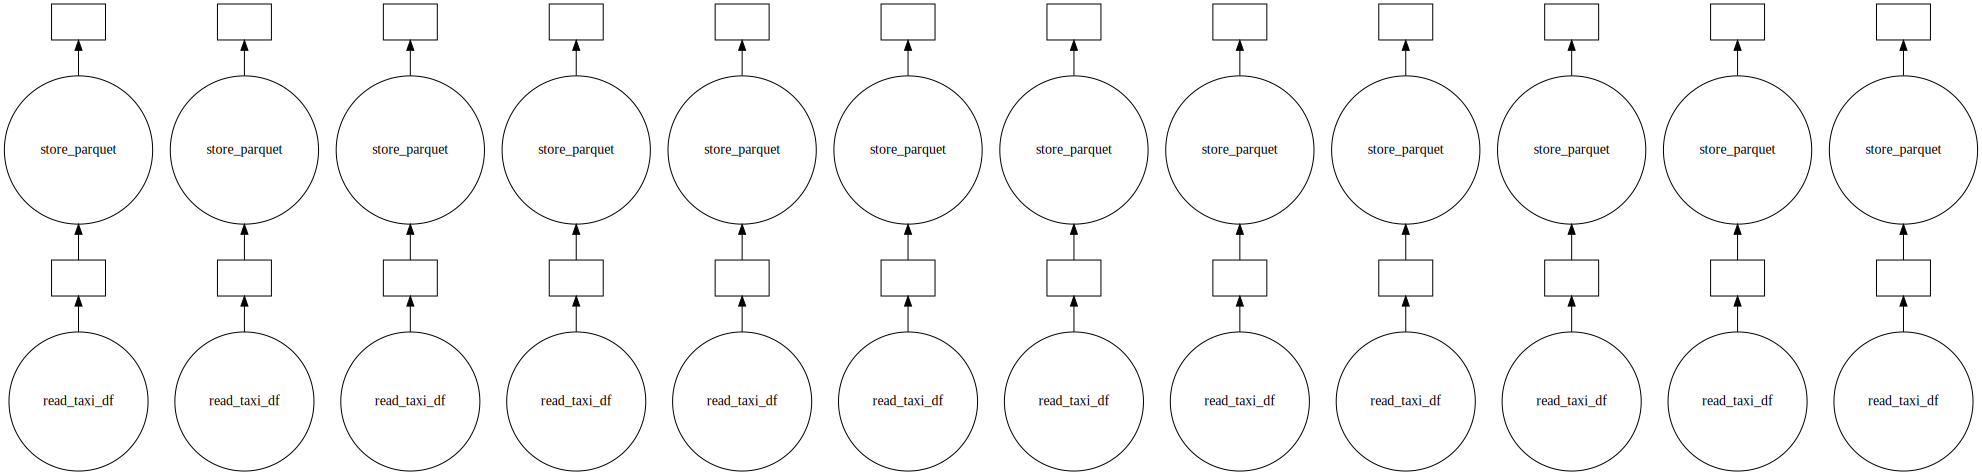

In [23]:
dask.visualize(tasks, filename="conver_parquet.svg")

In [ ]:
# Client.compute dispatches the computations lazily, i.e. control is immediately returned opposed to plain dask.compute!
future = client.compute(tasks)

In [ ]:
from distributed import progress

progress(future)

## How to do it right?

In [ ]:
%load solutions/03_convert_parquet.py

In [24]:
import dask.dataframe as dd

ddf = dd.read_csv(os.path.join(nytaxi_directory, "*.csv"))
dd.to_parquet(ddf, nytaxi_parquet_directory, engine="pyarrow")

distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [25]:
import dask.dataframe as dd

ddf = dd.read_csv(os.path.join(nytaxi_directory, "*.csv"))
dd.to_hdf(ddf, "/data", nytaxi_parquet_directory)

ImportError: Missing optional dependency 'tables'.  Use pip or conda to install tables.

## Remote files

* Files are not always local to the worker.
* In HPC systems, there is often a cluster filesystem 
* Otherwise:
 * Filesystems: http://dask.pydata.org/en/latest/remote-data-services.html
 * Simple Storage: https://github.com/mbr/simplekv / https://github.com/blue-yonder/storefact
* Table management w/ atomic mutations, indexing, etc.: https://github.com/JDASoftwareGroup/kartothek